# Исследование объявлений о продаже квартир

Представлены данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Определим рыночную стоимость объектов недвижимости.  
Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Открываем файл с данными и изучаем общую информацию. 

#### Загрузка используемых библиотек.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Загрузка данных в датафрейм.

In [2]:
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    try:
        data = pd.read_csv(r'C:\Users\New\Documents\dataset\appartament')
    except:
        data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')

#### Общая информация о полученном датафрейме.

In [3]:
display(data.head())
data.info()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

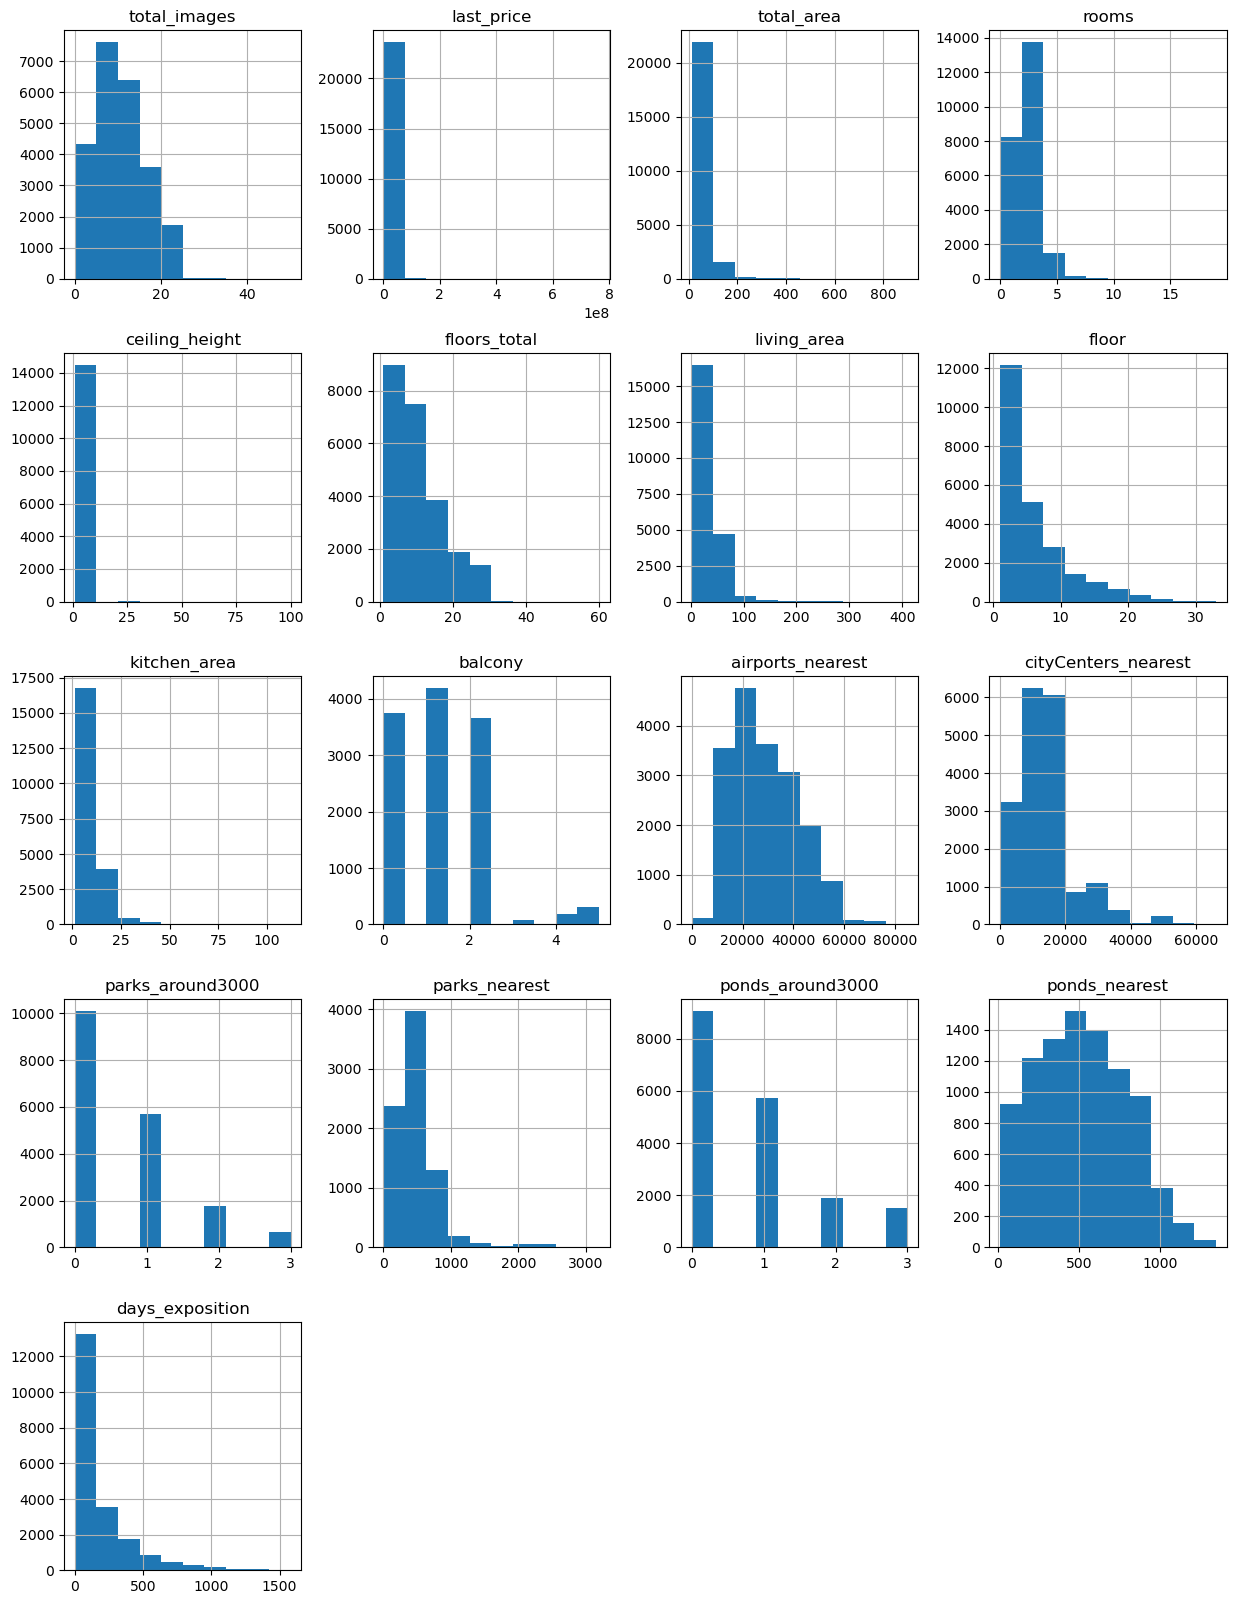

In [4]:
data.hist(figsize=(15, 20));

Мы имеем данные: 22 колонки и 23699 строк обьявлений. Присутствуют пропуски в значениях.  
По выведенным гистограммам можно сказать, что они мало информативны: Мало различимы выбросы. Не видны пропущенные значения и не видны аномалии.  
Этим мы займемся в предобработке данных.

### Предобработка данных  
#### Предобработка пропущенных значений  
Сперва необходимо понимать, в каких столбцах существуют пропуски.

In [5]:
round(data.isna().sum()/len(data)*100, 2)

total_images             0.00
last_price               0.00
total_area               0.00
first_day_exposition     0.00
rooms                    0.00
ceiling_height          38.80
floors_total             0.36
living_area              8.03
floor                    0.00
is_apartment            88.29
studio                   0.00
open_plan                0.00
kitchen_area             9.61
balcony                 48.61
locality_name            0.21
airports_nearest        23.38
cityCenters_nearest     23.29
parks_around3000        23.28
parks_nearest           65.91
ponds_around3000        23.28
ponds_nearest           61.56
days_exposition         13.42
dtype: float64

**Пропущенные значения**:  
  
В столбцах  "высота потолков" `ceiling_height` очень редко встречаются потолки больше 10 метров, по этому будем считать это ошибочным вводом и разделим их на 10. Пропуски заменим медийным значением однотипных домов. Остальные значения, не имеют взаимосвязей, по этому их просто приравняем к минимальному значению, что не повлияет надальнейшую обработку. 
"жилая площадь" (living_area) и "площадь кухни" (kitchen_area) можно заменить медийным значением однотипных домов.  
  
Перед заполнением пропусков в столбце "высота потолков" (ceiling_height) уберем аномальные значения, которые будут явно завышать медийные значения. 

In [6]:
for t in data['ceiling_height'].unique():
    data.loc[(data['ceiling_height'] == t) & (data['ceiling_height'] > 10),'ceiling_height'] = data['ceiling_height']/ 10

def calculate_median (col_name):
    for t in data['floors_total'].unique():
        data.loc[(data['floors_total'] == t) & (data[col_name].isna()), col_name] = \
        data.loc[(data['floors_total'] == t), col_name].median()


calculate_median('ceiling_height')
data['ceiling_height'] = data['ceiling_height'].fillna(2.5)
print(data['ceiling_height'].isna().sum())

0


Для исключения дублирования действий создана функция заполнения пропусков. 
Для исключения неккоретной замены медийного значения, применили условие. общая площадь квартиры не привышает суммы площадей жилой и кухни, так же 10% на нежилую прощадь и балкон.

In [7]:
def calculate_median (col_name,col2_name):
    rows = (data[col_name] < ((data['total_area']*0.9) - data[col2_name]))
    for t in data['floors_total'].unique():
        data.loc[(data['floors_total'] == t) & (data[col_name].isna()) & (rows == True), col_name] = \
        data.loc[(data['floors_total'] == t), col_name].median()

calculate_median('living_area','kitchen_area')
calculate_median('kitchen_area','living_area')

В столбце Аппартаменты (is_apartment) принимаем пропуски за False.

In [8]:
data['is_apartment'] = data['is_apartment'].fillna(False)

Пропуски в столбце "название населённого пункта" `locality_name` будут удалены. всего 5 строк и крайне мало информации для реального обьявления.

In [9]:
display(data.loc[data['locality_name'].isna()==True].head())
data = data.dropna(subset=['locality_name', 'floors_total']).reset_index(drop=True)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1097,3,8600000.0,81.7,2016-04-15T00:00:00,3,3.55,5.0,50.8,2,False,...,8.8,0.0,NaN,23478.0,4258.0,0.0,NaN,0.0,NaN,147.0
2033,6,5398000.0,80.0,2017-05-30T00:00:00,3,3.00,4.0,42.6,2,False,...,18.6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.0
2603,20,3351765.0,42.7,2015-09-20T00:00:00,1,2.75,24.0,15.6,3,False,...,10.7,0.0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,276.0
2632,2,5130593.0,62.4,2015-10-11T00:00:00,2,2.75,24.0,33.1,21,False,...,8.2,0.0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,256.0
3574,10,4200000.0,46.5,2016-05-28T00:00:00,2,2.55,5.0,30.8,5,False,...,6.5,0.0,NaN,27419.0,8127.0,0.0,NaN,1.0,603.0,45.0


Пропуски в столбце `balcony` явно указывают на их отсутствие. Заменим их на 0.
Вероятнее всего, если пропуски в значениях парки `parks_around3000` и водоемы в радиусе 3км `ponds_around3000`, то их просто нет и можно заменить из на 0.  
Остальные пропуски не имеют явной взаимосвязи и на общую картину для аналитики не повлияют, по этому заменим их на 0.

In [10]:
data['balcony'] = data['balcony'].fillna('0')
data['parks_around3000'] = data['parks_around3000'].fillna('0')
data['ponds_around3000'] = data['ponds_around3000'].fillna('0')

Приведем в один стиль назчание колонок:  `cityCenters_neares` приведем к стилю **snake_casse** 

In [11]:
data = data.rename(columns= {'cityCenters_nearest': 'city_centers_nearest'})

In [12]:
display(data.head())
data.isna().sum()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,False,...,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,2.75,11.0,18.6,1,False,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.55,5.0,34.3,4,False,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.60,14.0,NaN,9,False,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,False,...,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area              1865
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2222
balcony                     0
locality_name               0
airports_nearest         5524
city_centers_nearest     5501
parks_around3000            0
parks_nearest           15535
ponds_around3000            0
ponds_nearest           14529
days_exposition          3171
dtype: int64

In [13]:
display(data.loc[data['days_exposition'].isna()== True].head(10))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,False,...,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
7,5,7915000.0,71.6,2019-04-18T00:00:00,2,2.75,24.0,NaN,22,False,...,18.9,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
44,13,5350000.0,40.0,2018-11-18T00:00:00,1,2.75,22.0,NaN,3,False,...,NaN,1.0,Санкт-Петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,NaN
45,17,5200000.0,50.6,2018-12-02T00:00:00,2,2.65,9.0,30.30,7,False,...,7.0,0,Санкт-Петербург,30011.0,12872.0,0.0,NaN,0.0,NaN,NaN
46,17,6600000.0,52.1,2019-01-31T00:00:00,2,2.60,24.0,29.70,9,False,...,8.3,2.0,Санкт-Петербург,15114.0,12702.0,0.0,NaN,0.0,NaN,NaN
49,1,3050000.0,30.8,2018-11-22T00:00:00,1,2.50,9.0,18.00,7,False,...,6.0,0,Санкт-Петербург,45341.0,16603.0,1.0,675.0,0.0,NaN,NaN
52,20,11795000.0,136.0,2017-09-22T00:00:00,6,3.00,2.0,94.00,2,False,...,11.0,1.0,Санкт-Петербург,16510.0,6582.0,1.0,526.0,0.0,NaN,NaN
71,20,4850000.0,57.5,2019-03-27T00:00:00,3,2.50,9.0,39.00,8,False,...,6.2,0,Санкт-Петербург,33623.0,12267.0,1.0,334.0,1.0,333.0,NaN
81,9,10949000.0,68.0,2018-12-27T00:00:00,1,2.60,10.0,NaN,6,False,...,NaN,0,Санкт-Петербург,NaN,NaN,0,NaN,0,NaN,NaN
84,11,2400000.0,43.9,2019-03-13T00:00:00,2,2.70,2.0,27.46,1,False,...,5.2,0,Кировск,NaN,NaN,0,NaN,0,NaN,NaN


Столбец `days_exposition` имеет пропуски в значениях из-за технической обработки. Скорее всего это незакрытые обьявления, заменить их не представляется возможным, по этому мы оставим их пустыми.

Остались колонки `airports_nearest`, `city_centers_neares`, `ponds_nearest`.  
Эти данные получены автоматически на основе картографических данных.  
Получается, что клиент не внес данные об адресе, следовательно их мы заменить не сможем.

#### Преобразование типов данных в каждом столбце.

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23565 non-null  int64  
 1   last_price            23565 non-null  float64
 2   total_area            23565 non-null  float64
 3   first_day_exposition  23565 non-null  object 
 4   rooms                 23565 non-null  int64  
 5   ceiling_height        23565 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           21700 non-null  float64
 8   floor                 23565 non-null  int64  
 9   is_apartment          23565 non-null  bool   
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          21343 non-null  float64
 13  balcony               23565 non-null  object 
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

**Меняем тип данных**

In [15]:
data.astype({'first_day_exposition': 'datetime64', 
             'floors_total': 'int64', 'balcony': 'int64',
             'last_price': 'int64', 'is_apartment': 'bool'}).dtypes

total_images                     int64
last_price                       int64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                     int64
living_area                    float64
floor                            int64
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                          int64
locality_name                   object
airports_nearest               float64
city_centers_nearest           float64
parks_around3000                object
parks_nearest                  float64
ponds_around3000                object
ponds_nearest                  float64
days_exposition                float64
dtype: object

Тип данных преобразуем в выбранных столбцах:

`first_day_exposition` - object(обьект) на datetime64(объекты даты и времени). Для дальнейшей работы с обьектами времени.  
`floors_total` - float64(Числа с плавающей точкой) на int (Целые числа). Этажность не может быть не целым числом.  
`balcony` - float64(Числа с плавающей точкой) на int (Целые числа). Число балконов должно быть целое.  
`is_apartment` - object(Текстовые или смешанные числовые и нечисловые значения) на bool (булево значение). Данные моут принимать только значение "Да" или "Нет".  
`days_exposition` - float64(Числа с плавающей точкой) на int (Целые числа). Количество дней может быть только целое.  

In [16]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,False,...,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,2.75,11.0,18.6,1,False,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.55,5.0,34.3,4,False,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.60,14.0,NaN,9,False,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,False,...,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


#### Устранение неявных дубликатов

Рассмотрев уникальные значения в столбце с названиями,  определяем неявные дубликаты. Решение избавиться от типа населенных пунктов более оптимальное.

In [17]:
data['locality_name'].nunique()

364

In [18]:
def replace_wrong_values(wrong_values, correct_value):
    for wrong_value in wrong_values: 
        data['locality_name'] = data['locality_name'].str.replace(wrong_value, correct_value)

duplicates = ['посёлок', 'посёлок городского типа', 'поселок городского типа', 
              'городской посёлок', 'городской поселок', 'поселок', 'деревня', 
              'садовое товарищество', 'село', 'садоводческое некоммерческое товарищество', 'коттеджный',' ']
name = ''
replace_wrong_values(duplicates, name)
data['locality_name'] = data['locality_name'].replace('Жил', 'Жилпосёлок') 
# Данный фильтр неидеальный, пришлось Вернуть название населенному пункту.
data['locality_name'].nunique()

326

38 неявных дубликатов исключили

#### Устранение данных - аномалий
Первым делом рассмотрим распределение значений функцией **describe()**


In [19]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,airports_nearest,city_centers_nearest,parks_nearest,ponds_nearest,days_exposition
count,23565.000000,2.356500e+04,23565.000000,23565.000000,23565.000000,23565.000000,21700.000000,23565.000000,21343.000000,18041.000000,18064.000000,8030.000000,9036.000000,20394.000000
mean,9.878421,6.540058e+06,60.322824,2.070656,2.708504,10.675875,34.454822,5.878124,10.560994,28797.082701,14192.656056,490.580448,518.289509,180.741395
std,5.681156,1.091093e+07,35.657060,1.078591,0.250726,6.594823,22.045359,4.871485,5.900630,12632.499735,8613.348153,341.572956,278.009558,219.732782
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,181.000000,1.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.550000,5.000000,18.600000,2.000000,7.000000,18565.000000,9238.000000,288.000000,293.000000,45.000000
50%,9.000000,4.646000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,26757.000000,13096.500000,455.000000,503.000000,95.000000
75%,14.000000,6.790000e+06,69.700000,3.000000,2.750000,16.000000,42.300000,8.000000,12.000000,37273.000000,16285.000000,612.000000,730.000000,231.000000
max,50.000000,7.630000e+08,900.000000,19.000000,10.000000,60.000000,409.700000,33.000000,112.000000,84869.000000,65968.000000,3190.000000,1344.000000,1580.000000


Из разпределения видны разбросы. Начнем с простого:  
  
Cтолбец "rooms'. Комнат больше 7-ми в квартире это редкость. Проверив все строки таблицы стало понятно, что это скорее техническая опечатка и она портит основную картину. Удалив строки теряем всего 0,13%.  
Так же комнат не может быть 0. Вероятнее клиенты не указали данный параметр при обьявлении аппартаментов или квартир со свободной планировкой. Заменим значением "1".

In [20]:
data['rooms'] = data['rooms'].replace(0, 1) 
data = data[data['rooms'] <=7]
print(data['rooms'].count())
data['rooms'].sort_values().unique()

23534


array([1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [21]:
print(data['ceiling_height'].sort_values().unique())

[ 1.    1.03  1.2   1.4   1.75  2.    2.2   2.25  2.26  2.3   2.34  2.4
  2.45  2.46  2.47  2.48  2.49  2.5   2.51  2.52  2.53  2.54  2.55  2.56
  2.57  2.58  2.59  2.6   2.61  2.62  2.63  2.64  2.65  2.66  2.67  2.68
  2.69  2.7   2.71  2.72  2.73  2.74  2.75  2.76  2.77  2.78  2.79  2.8
  2.81  2.82  2.83  2.84  2.85  2.86  2.87  2.88  2.89  2.9   2.91  2.92
  2.93  2.94  2.95  2.96  2.97  2.98  2.99  3.    3.01  3.02  3.03  3.04
  3.05  3.06  3.07  3.08  3.09  3.1   3.11  3.12  3.13  3.14  3.15  3.16
  3.17  3.18  3.2   3.21  3.22  3.23  3.24  3.25  3.26  3.27  3.28  3.29
  3.3   3.31  3.32  3.33  3.34  3.35  3.36  3.37  3.38  3.39  3.4   3.42
  3.44  3.45  3.46  3.47  3.48  3.49  3.5   3.51  3.52  3.53  3.54  3.55
  3.56  3.57  3.58  3.59  3.6   3.62  3.63  3.65  3.66  3.67  3.68  3.69
  3.7   3.75  3.76  3.78  3.8   3.82  3.83  3.84  3.85  3.86  3.87  3.88
  3.9   3.93  3.95  3.98  4.    4.06  4.1   4.14  4.15  4.19  4.2   4.25
  4.3   4.37  4.4   4.45  4.5   4.65  4.7   4.8   4.9

Ранее при обработке пропущенных значениях были устранены аномалии связанные с опечаткой высоты более 10м.  
Значения более 8 м и менее 2.5м скорее всего аномалии, которые не поддаются логике. Отбросив их мы потерям всего 15% строк от общего количества строк таблицы, что является критичным, по этому заменим значения менее 2.5 м минимально предельным значением - 2.5м., а более 8м исключим, что не сильно исказит дальнейший анализ (0,02%). 

In [22]:
for t in data['ceiling_height'].unique():
    data.loc[(data['ceiling_height'] == t) & (data['ceiling_height'] < 2.5), 'ceiling_height'] = 2.5

data = data[data['ceiling_height'] < 8]

data['ceiling_height'].count()

23529

Проверим значение этажа в обьявлении(floor). Оно не должно превышать floors_total (всего этажей в доме).

In [23]:
data = data[(data['floor'] <= data['floors_total'])]
print(data['floor'].sort_values().unique())
data['floor'].count()

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]


23529

Отбросив некорректный ввод значений столбца "этажность" мы теряем 0,36%.  
  
Общая площадь квартиры складывается из площади кухни, жилой площади (как правило это 90%), а так же балконом, коридором, ванной комнатой и туалетом (оставшиеся 10%).  
Применим данное условие к нашей таблице. Все обьевления не вошедшие в это условие отбросим.(потеряем 5,7%)

In [24]:
data = data[(data['total_area']*0.9) >= (data['living_area']+ data['kitchen_area'])]
data['total_area'].count()

20414

Значения более 250 кв м. в жилой площади вероятнее всего являются аномалиями. Попробуем их проанализировать.

count    20414.000000
mean        34.098698
std         20.587728
min          2.000000
25%         18.600000
50%         30.000000
75%         42.100000
max        347.500000
Name: living_area, dtype: float64
[51.   18.6  34.3  ... 31.65 13.59 42.55]


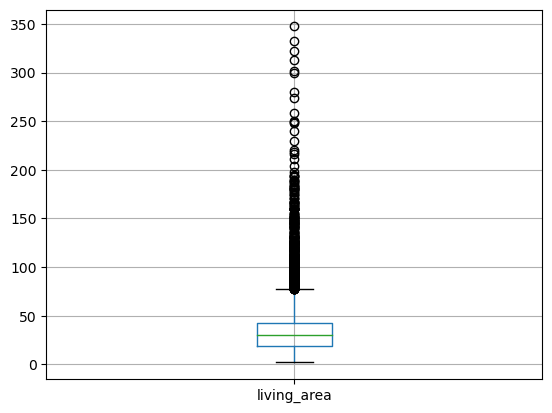

In [25]:
print(data['living_area'].describe())
print(data['living_area'].unique())
data.boxplot(column = 'living_area'); 

Медийное значение 33, а максимальное 332. Также на графике видно, что значения более 200 редкие, и ими можно принебечь, неискажая общую картину.

In [26]:
data = data[(data['living_area'] < 200)]
data['living_area'].count()

20395

Предложение верное. Потери всего 0,09%  
  
Площадь кухни так же имеет выбросы.

count    20395.000000
mean        10.355949
std          5.390333
min          1.300000
25%          7.000000
50%          9.000000
75%         11.800000
max        107.000000
Name: kitchen_area, dtype: float64


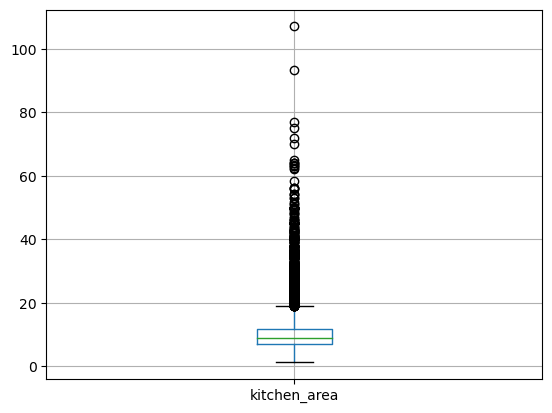

In [27]:
print(data['kitchen_area'].describe())
data.boxplot(column = 'kitchen_area'); 

Площадь кухни скорее всего имеют аномальные значения больше 60 кв м. Исключим строки, где площадь кухни больше 60 и посмотрим % исключения.

In [28]:
data = data[data['kitchen_area'] < 60]
data['kitchen_area'].count()

20380

Потери всего 0,07%  

Проверим цену на момент снятия публикации:
Для наглядности приведем цену в тысячи.

In [29]:
data['last_price'] = round(data['last_price']/1000, 2)

count     20380.000000
mean       6270.111768
std        7608.821093
min          12.190000
25%        3500.000000
50%        4667.500000
75%        6700.000000
max      330000.000000
Name: last_price, dtype: float64
[13000.    3350.    5196.   ...  6151.12 21400.    9470.  ]


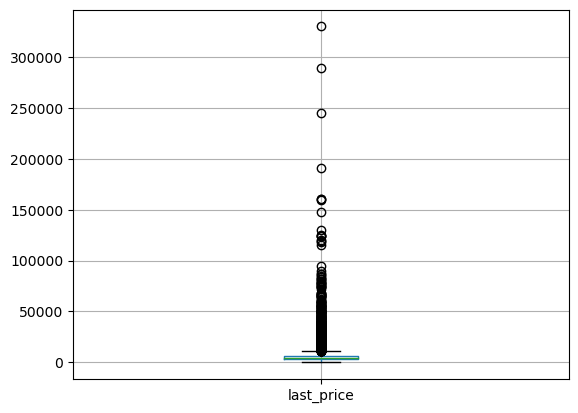

In [30]:
print(data['last_price'].describe())
print(data['last_price'].unique())
data.boxplot(column = 'last_price');

Цена скорее всего имеет аномальные значения после 150 млн. Исключим строки, больше 150 000 и посмотрим %

In [31]:
data = data[data['last_price'] < 150000]
data['last_price'].count()

20373

Потери всего 0,03%
  
Таким образом были устранены аномалии. Удалены строки всего на 6,4% из общего объёма таблицы.

### Подсчет и добавление в таблицу новых столбцов

Создадим столбец - цена одного квадратного метра.  
Округляем для наглядности до 2х знаков.

In [32]:
data['price_one_metr'] = round((data['last_price'] / data['total_area']),2) 

Создадим столбец - день недели публикации объявления (0 — понедельник, 1 — вторник и так далее).  
Убираем нулевые значения часов и минут для красоты графиков.

In [33]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d')
data['weekdays'] = data['first_day_exposition'].dt.weekday

Создадим столбец - месяц публикации объявления.

In [34]:
data['Month'] = data['first_day_exposition'].apply(lambda time: time.month)

Создадим столбец - год публикации объявления.

In [35]:
data['Year'] = data['first_day_exposition'].apply(lambda t: t.year)
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_metr,weekdays,Month,Year
0,20,13000.0,108.00,2019-03-07,3,2.70,16.0,51.00,8,False,...,16028.0,1.0,482.0,2.0,755.0,NaN,120.37,3,3,2019
1,7,3350.0,40.40,2018-12-04,1,2.75,11.0,18.60,1,False,...,18603.0,0.0,NaN,0.0,NaN,81.0,82.92,1,12,2018
2,10,5196.0,56.00,2015-08-20,2,2.55,5.0,34.30,4,False,...,13933.0,1.0,90.0,2.0,574.0,558.0,92.79,3,8,2015
4,2,10000.0,100.00,2018-06-19,2,3.03,14.0,32.00,13,False,...,8098.0,2.0,112.0,1.0,48.0,121.0,100.00,1,6,2018
5,10,2890.0,30.40,2018-09-10,1,2.65,12.0,14.40,5,False,...,NaN,0,NaN,0,NaN,55.0,95.07,0,9,2018
6,6,3700.0,37.30,2017-11-02,1,2.66,26.0,10.60,6,False,...,19143.0,0.0,NaN,0.0,NaN,155.0,99.20,3,11,2017
8,20,2900.0,33.16,2018-05-23,1,2.70,27.0,15.43,26,False,...,NaN,0,NaN,0,NaN,189.0,87.45,2,5,2018
9,18,5400.0,61.00,2017-02-26,3,2.50,9.0,43.60,7,False,...,15008.0,0.0,NaN,0.0,NaN,289.0,88.52,6,2,2017
10,5,5050.0,39.60,2017-11-16,1,2.67,12.0,20.30,3,False,...,13878.0,1.0,310.0,2.0,553.0,137.0,127.53,3,11,2017
11,9,3300.0,44.00,2018-08-27,2,2.55,5.0,31.00,4,False,...,51677.0,0.0,NaN,0.0,NaN,7.0,75.00,0,8,2018


Создадим столбец и определим тип этажа квартиры (значения — «первый», «последний», «другой»).

In [36]:
def floor_group(col_floor):
    for i in data['floors_total']:
        if  col_floor == 1:
            return 'первый'
        elif   col_floor == i:
            return 'последний'
        elif (col_floor != 1) & (col_floor != i):
            return 'другой'
        
data['type_floor'] = data['floor'].apply(floor_group)

Создадим столбец - расстояние до центра города в километрах (переведем из м в км и округлим до целых значений).

In [37]:
data['city_centers_nearest'] = round(data['city_centers_nearest']/1000, 0)

### Исследовательский анализ данных

#### Изучение объектов:  

- общая площадь.

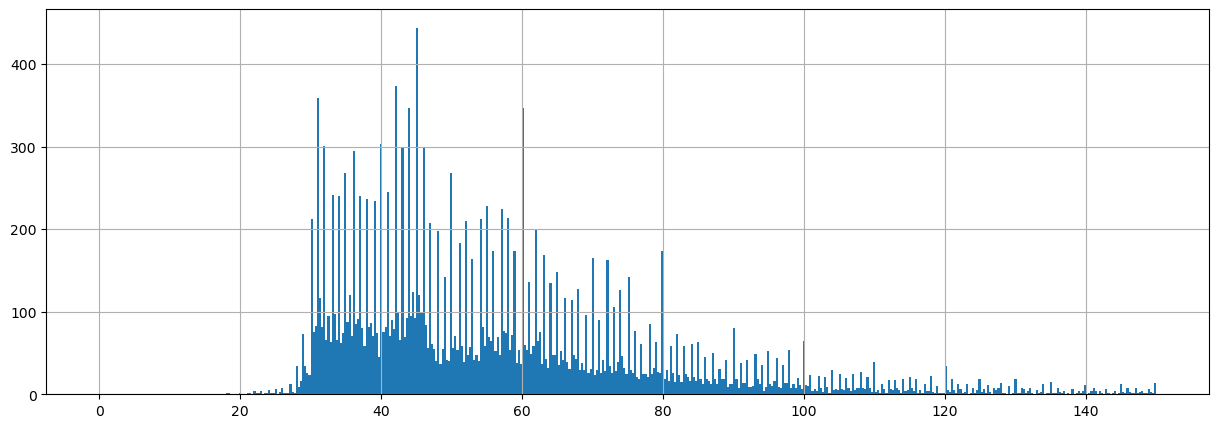

In [38]:
data['total_area'].hist(bins = 500, range = (0, 150), figsize = (15, 5));

По данной гистограмме видно, что чаще в обьявлениях выставляют квартиры с общей площадью, в диапазоне от 30 до 100 кв.м.
Свыше 110 кв.м реже. Из общего вида можно выделить объявления с 50 кв.м.их порядка 750шт. Значений начиная с 200 кв.м. очень мало. Есть выбросы на 500кв.м.
  
- жилая площадь

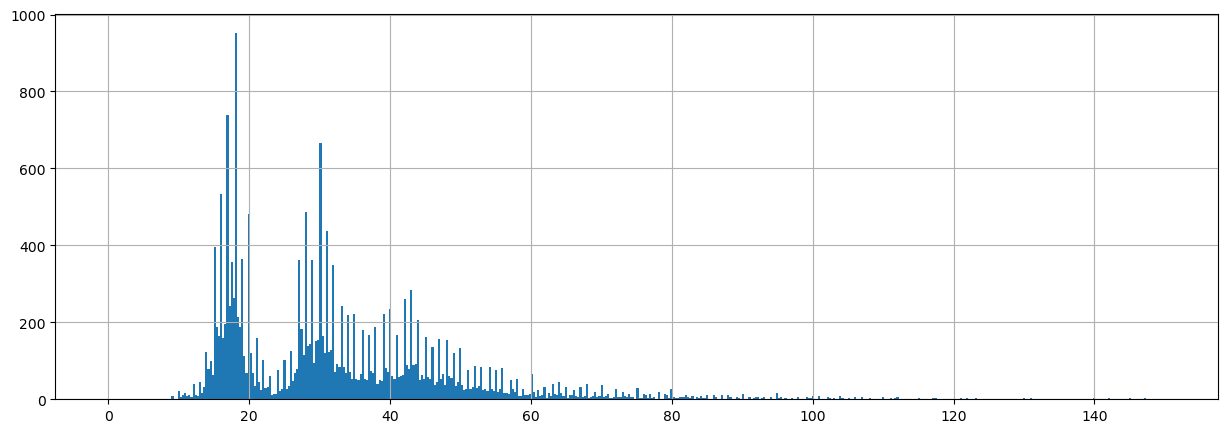

In [39]:
data['living_area'].hist(bins = 500, range = (0, 150), figsize = (15, 5));

По данной гистограмме видно, что  жилая площадь имеет несколько пиков значений: в районе 20, 30 и 40 кв.м., выделить можно значения в районое 20 кв.м. с числом обьявлений 1100шт и 30 кв.м. с 1450шт. Начиная с 70 кв.м. значений очень мало. Есть выбросы в районе 200 кв.м.  
  
- площадь кухни

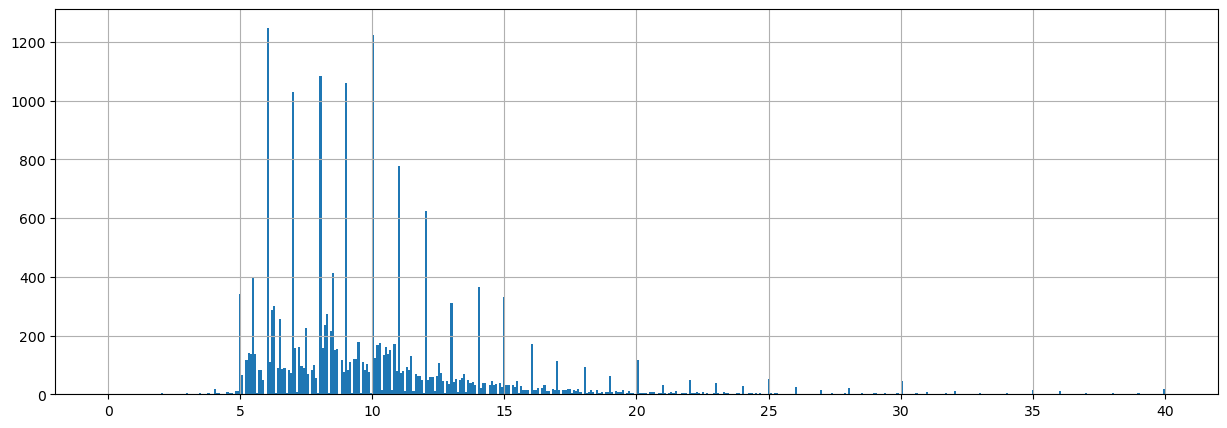

In [40]:
data['kitchen_area'].hist(bins = 500, range = (0, 40), figsize = (15, 5));

По гистограмме по "площадь кухни" видно, что  пик значений от 5 до 20кв.м, выделить можно значение в районе 7кв.м. и 6кв.м таких обьявлений порядка 3000шт. Начиная с 20кв.м. значений очень мало.
  
- цена объекта

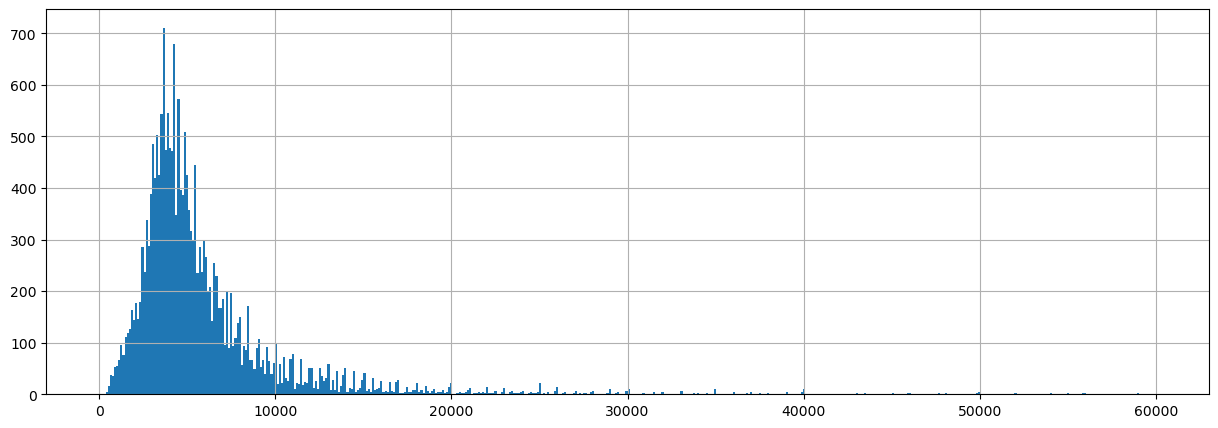

In [41]:
data['last_price'].hist(bins = 500, range = (0, 60000),figsize = (15, 5));

По гистограмме "цена (в тыс руб)" видно, что  пик значений - от 1 до 10млн, выделить можно значение в районе 4-5млн.рублей, таких обьявлений больше всего. Стоимость 10млн. и более встречается редко. 
  
- количество комнат

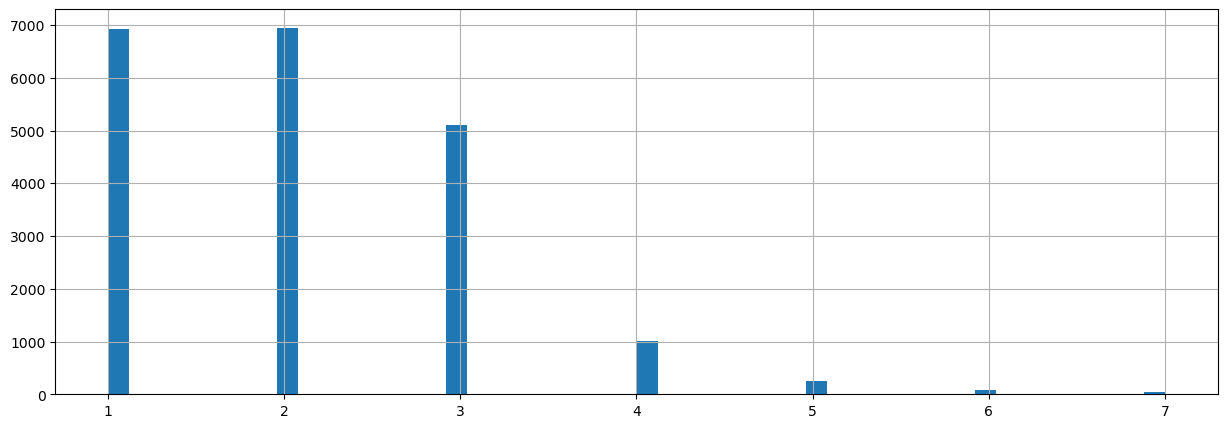

In [42]:
data['rooms'].hist(bins = 50, figsize = (15, 5));

По гистограмме "число комнат" видно, что  пик значений 1, 2, 3, выделить можно объявления 2-х комнатных кватрир, таких обьявлений больше всего. Редкими можно назвать квартиры с 7 комнатами.  
  
 - высота потолков

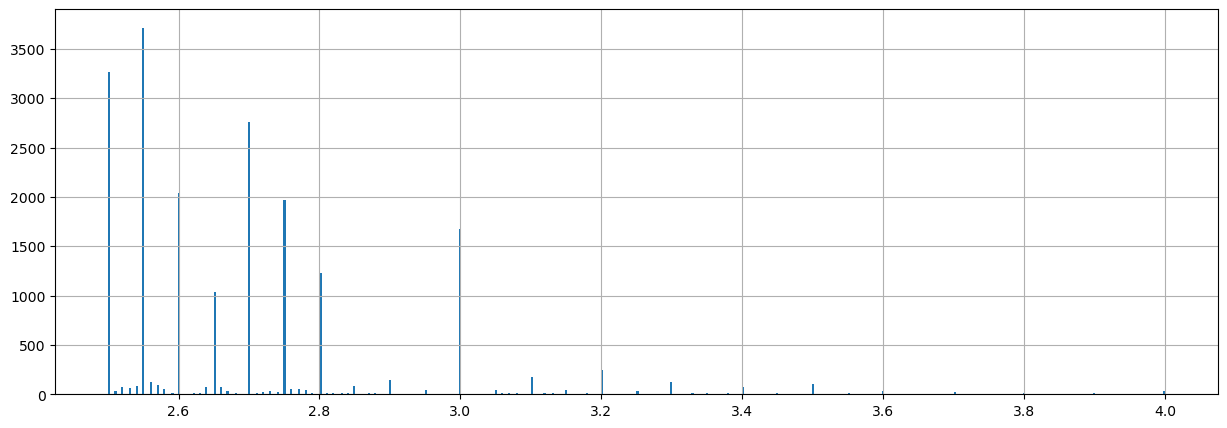

In [43]:
data['ceiling_height'].hist(bins = 500, range = (2.5,4), figsize = (15, 5));

По гистограмме "высота потолков" видно, что  пик значений в диапазоне от 2,5 до 2.8м, выделить можно значения 2,5, 2,55, 2,7, 2,75, 2,8 и 3м. Объявлений с потолками в 2,55м больше всего. Высота более 3м встречается редко.
  
- этаж квартиры

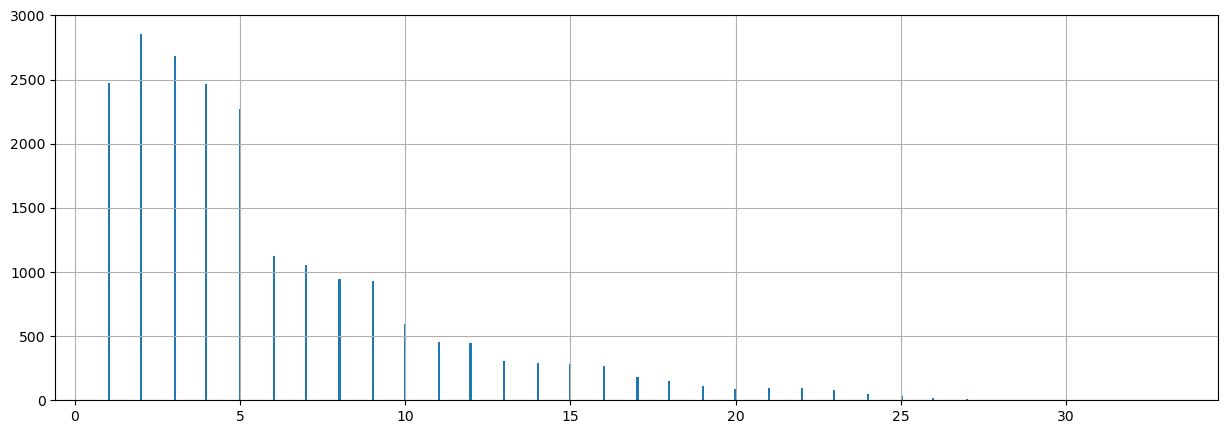

In [44]:
data['floor'].hist(bins = 500, figsize = (15, 5));

По гистограмме "этаж" видно, что  пик значений от 1 до 17 этажа. Выделить можно диапазон значений 1-5 этаж они самые распространенные. Объявлений на 2м этаже больше всего. Квартиры на 20 этаже и выше встречаются редко.  
Возможно, что застройка высокоэтажных домов не сильно развита.
  
- тип этажа квартиры («первый», «последний», «другой»)

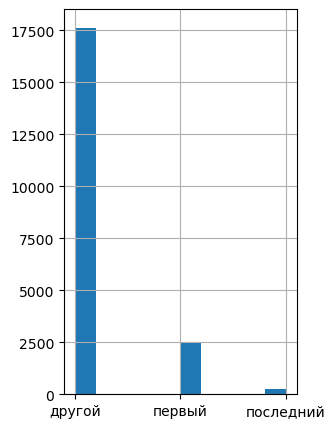

In [45]:
data['type_floor'].hist(bins = 10, figsize = (3, 5));

По гистограмме "тип этажности" видно, что число квартир по типу "другой" (ни первый, ни последний этаж) преобладает среди общей массы в районе 88%. Объявлений первых этажей всего 10%, а последних крайне мало - около 2%.

- общее количество этажей в доме;

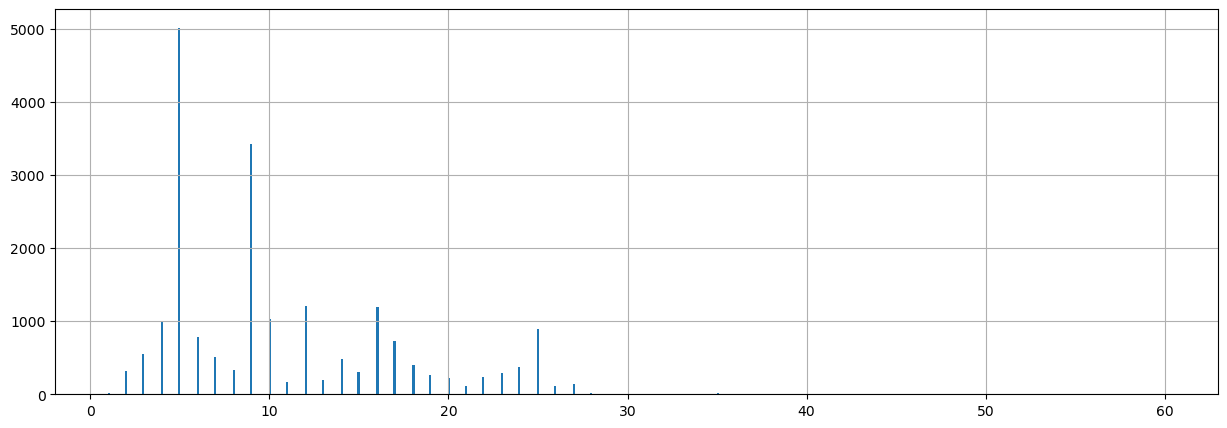

In [46]:
data['floors_total'].hist(bins = 500, figsize = (15, 5));

По гистограмме "всего этажей в доме" видно, что  чаще выставляли на продажу квартиры в 5 этажных и 9 этажных домах, выделить можно значения 25 этажные дома, их так же выставляют часто. Возможно это обусловлено массовой застройкой однотипных домов.

- расстояние до центра города в километрах

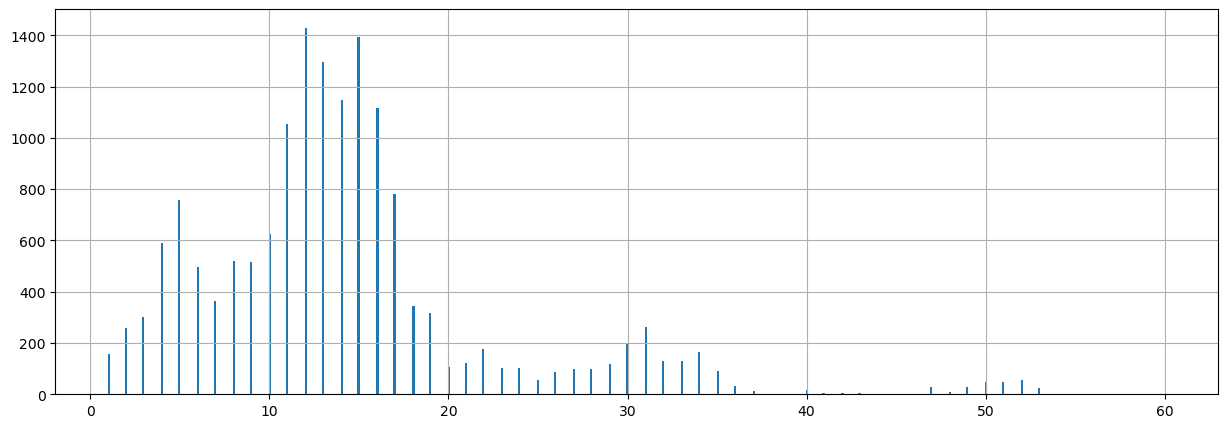

In [47]:
data['city_centers_nearest'].hist(bins = 500, range=(1,60),figsize = (15, 5));

Пик значений - от 1 до 20км, выделить можно значения в районе 11-15км. Объявлений в центре города больше всего. Удаленность от центра более 40км встречается редко. Есть выбросы в районе 30 и 50 км.

- расстояние до ближайшего аэропорта

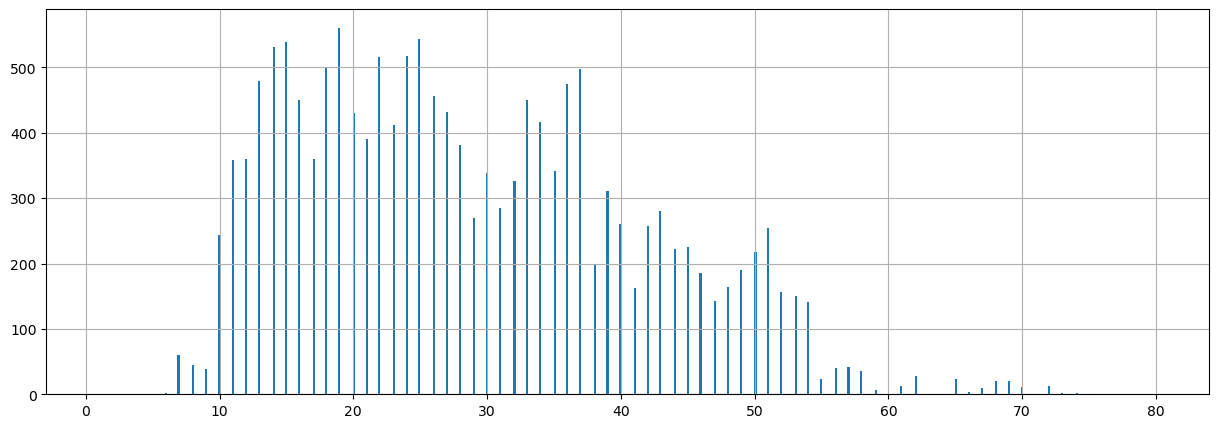

In [48]:
data['airports_nearest'] = round(data['airports_nearest']/1000, 0)
data['airports_nearest'].hist(bins = 500, range= (1, 80), figsize = (15, 5));

Зная, что ранее, при предобработки значений, были удалены пустые значения, в гистограмме учитывать значения с "расстоянием до аэропорта" равное 0 не будем. Для удобства расстояния будем выводить в километрах.   
По гистограмме видно, что  пик значений колеблется от 7 до 54км, выделить можно значения в районе 20км.  
Объявления с расстоянием более 60км встречается редко.

- расстояние до ближайшего парка

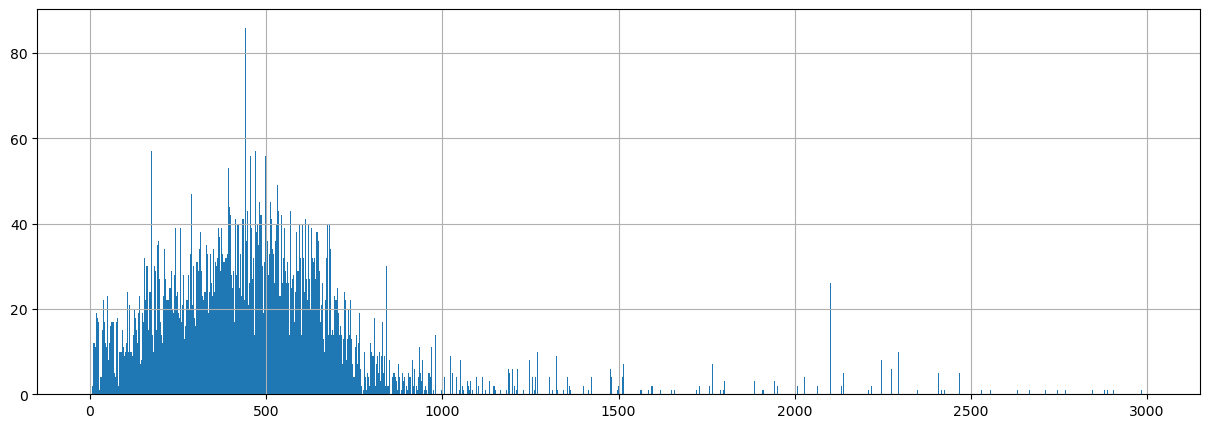

In [49]:
data['parks_nearest'].hist(bins = 1000, range = (1,3000),figsize = (15, 5));

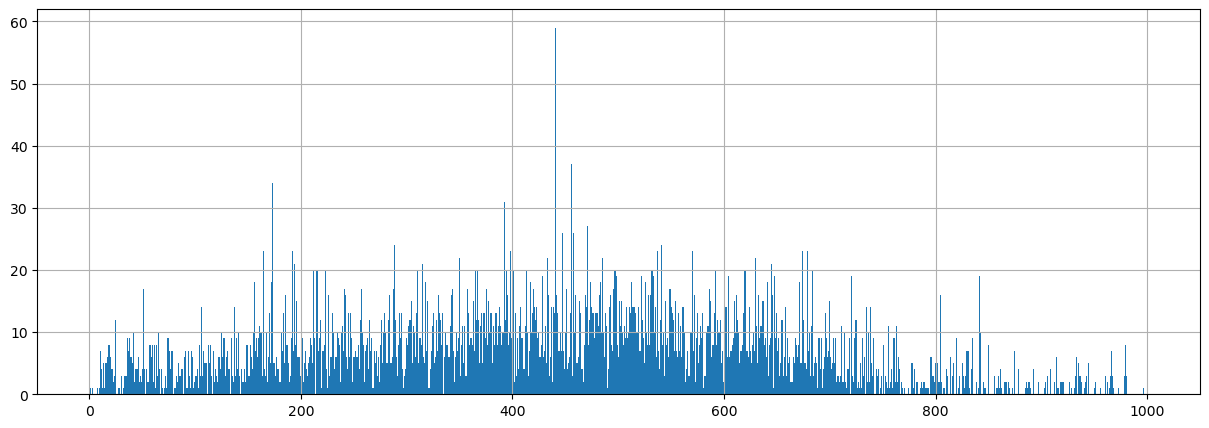

In [50]:
data['parks_nearest'].hist(bins = 1000, range = (1,1000),figsize = (15, 5));

На укрупненной гистограмме пик значений от 0 до 800м виден намного интереснее, выделить можно значения в районе 350-600м - больше всего объявлений. Расстояние более 1000м встречается редко. Выброс в районе 2200м может быть обусловлен отдельным микрорайоном или пром. зоной.
  
- день публикации объявления

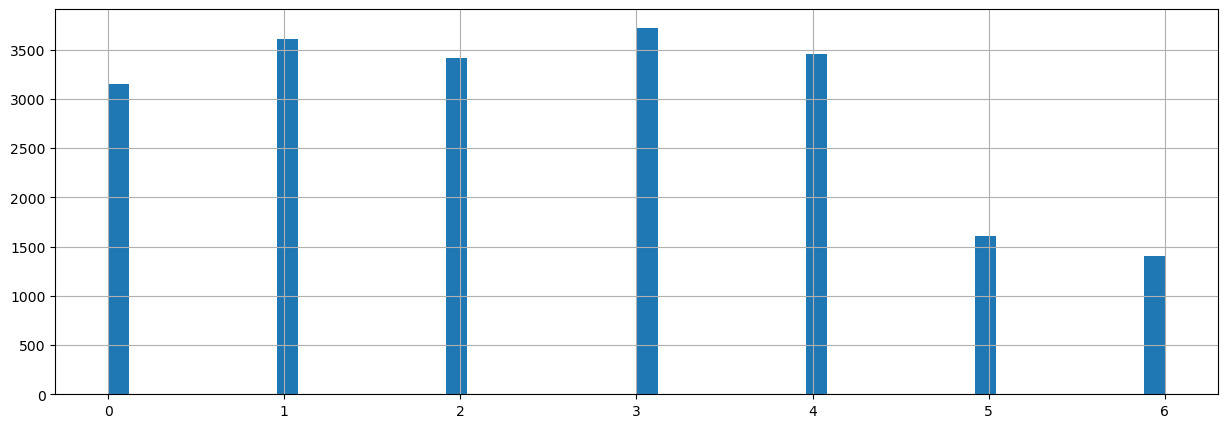

In [51]:
data['weekdays'].hist(bins = 50, figsize = (15, 5));

Можно сделать вывод, что в будние дни объявления публиковались чаще. Чаще всего их публиковали в четверг. Реже всего - в воскресенье.

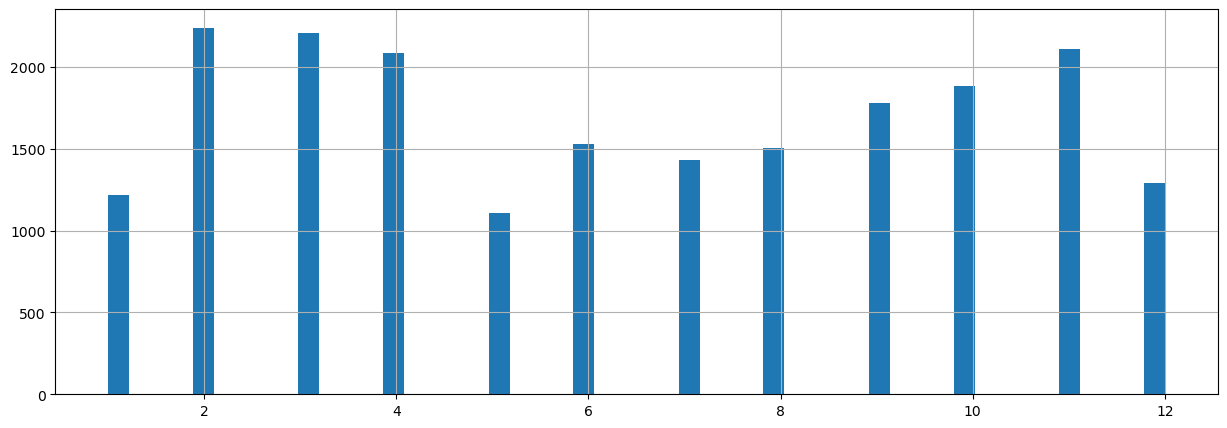

In [52]:
data['Month'].hist(bins = 50, figsize = (15, 5));

Если смотреть по месяцам, то меньше всего публиковали объявления в Мае и Январе. Больше всего - Февраль, Март, Апрель и Ноябрь.

#### Как быстро продавались квартиры (столбец `days_exposition`). 
Этот параметр показывает, сколько дней было размещено каждое объявление.

In [53]:
print(data['days_exposition'].describe())

count    17578.000000
mean       185.364717
std        221.717224
min          1.000000
25%         45.000000
50%        102.000000
75%        239.000000
max       1580.000000
Name: days_exposition, dtype: float64


Медийное значение продаж 102 дня. Быстрая продажа 1 днень, долгие 239 дней и выше. Рассмотрим гистограмму.

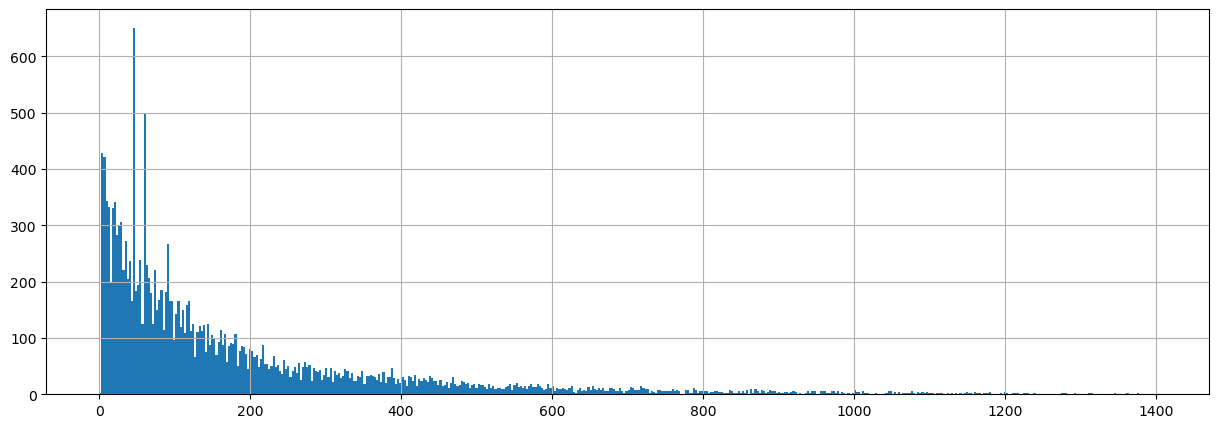

In [54]:
data['days_exposition'].hist(bins = 500, range = (0.1, 1400), figsize = (15, 5));

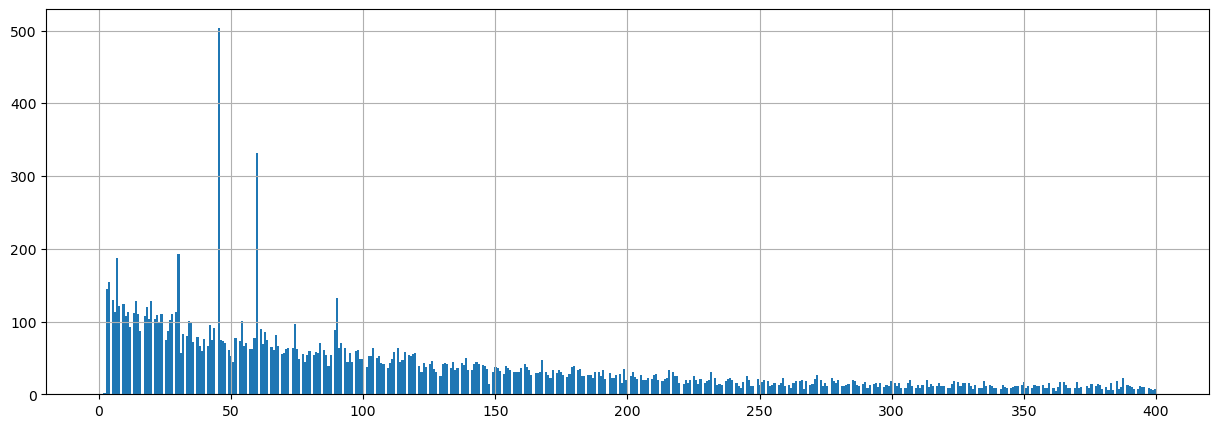

In [55]:
data['days_exposition'].hist(bins = 500, range = (0.1, 400), figsize = (15, 5));

Выбросами считаем 500 дней они являются аномалиями.
На укрупненной гисторамме видны пики в районе 40 и 60 дней. Это говорит, о том, что в большинстве случаев этих дней достаточно для продажи. По этому среднее время продажи можно считать 50 дней.

#### Какие факторы больше всего влияют на общую (полную) стоимость объекта?
 Изучим, зависит ли цена от:
- общей площади;
- жилой площади;
- площади кухни;
- количества комнат;
- этажа, на котором расположена квартира (первый, последний, другой);
- даты размещения (день недели, месяц, год).

0.7371467858826153


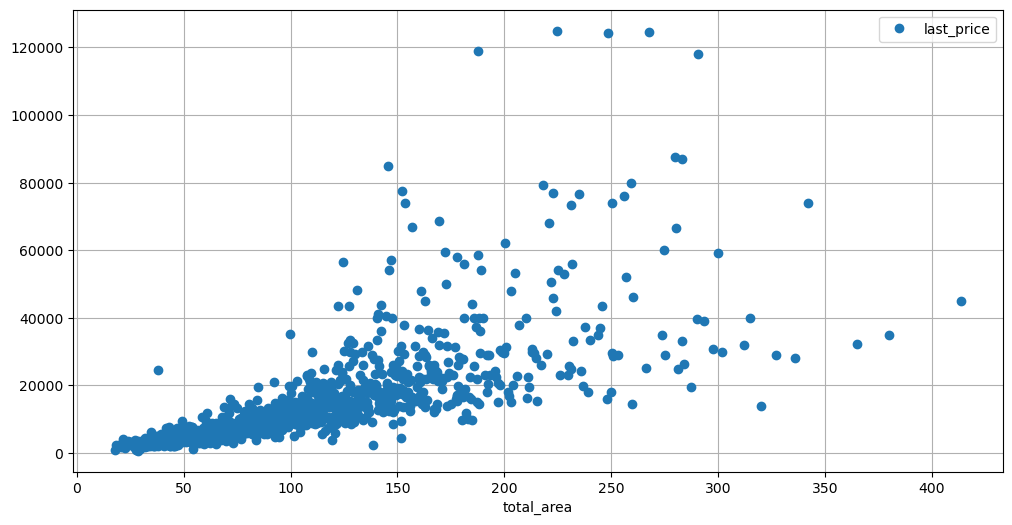

In [56]:
data.pivot_table(index = 'total_area', values = 'last_price').plot(style='o', grid=True, figsize=(12, 6));
print(data['total_area'].corr(data['last_price']))

Видно, как цена растет при увеличении общей площади в обьявлении. Зависимость кореляции 72%.

0.6519676079395887


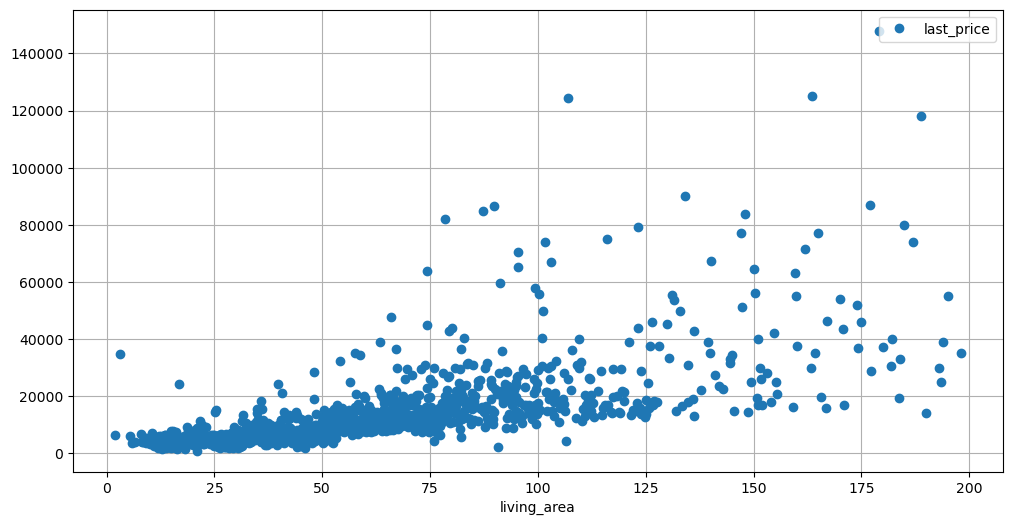

In [57]:
data.pivot_table(index = 'living_area', values = 'last_price').plot(style='o', grid=True, figsize=(12, 6));
print(data['living_area'].corr(data['last_price']))

Видно, как цена растет при увеличении жилой площади в обьявлении. Зависимость кореляции 64%.

0.5426621744571628


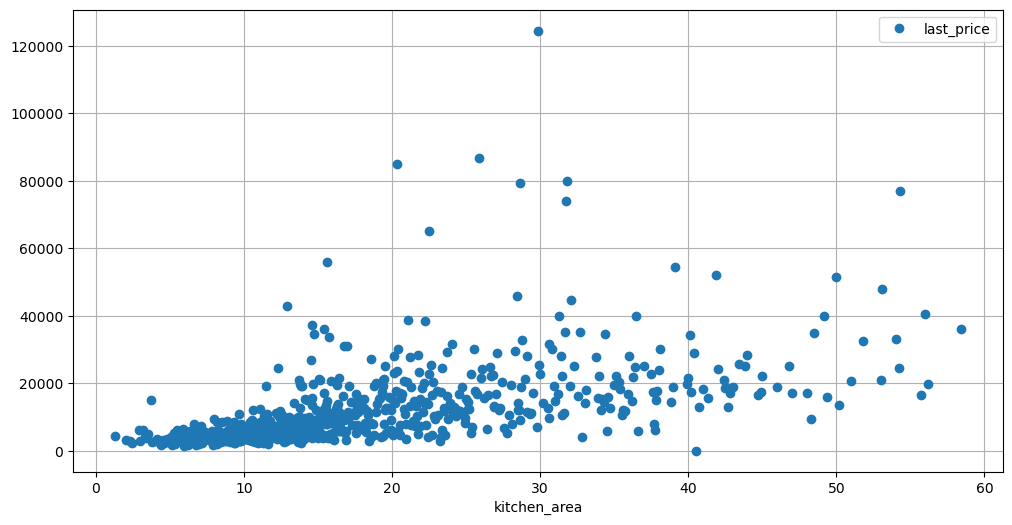

In [58]:
data.pivot_table(index = 'kitchen_area', values = 'last_price').plot(style='o', grid=True, figsize=(12, 6));
print(data['kitchen_area'].corr(data['last_price']))

Видно, как цена растет при увеличении площади кухни в обьявлении. Зависимость 54%.

0.5426621744571628


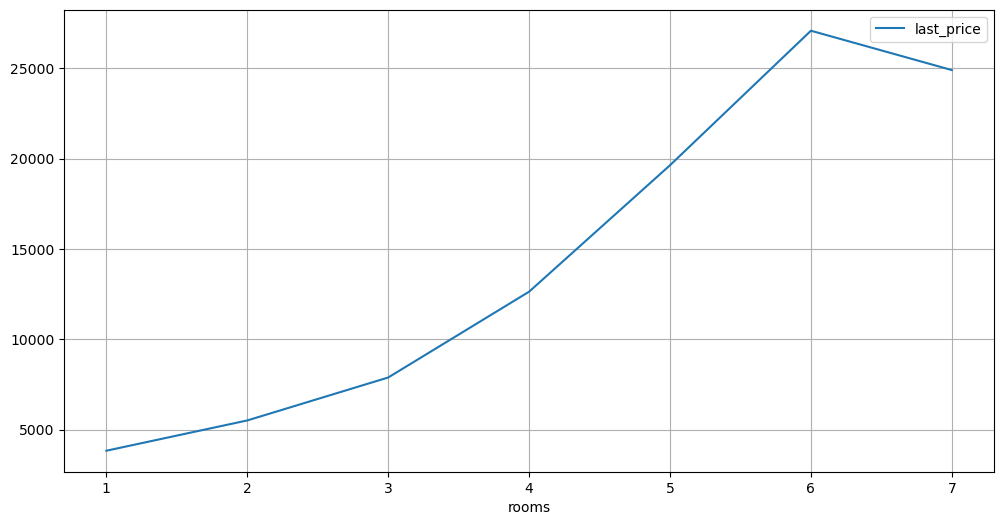

In [59]:
data.pivot_table(index = 'rooms', values = 'last_price').plot(grid=True, figsize=(12, 6));
print(data['kitchen_area'].corr(data['last_price']))

На данном графике видно, как цена падает, при объявлении квартиры с 7-ю комнатами. Кореляция всего 52%

0.5426621744571628


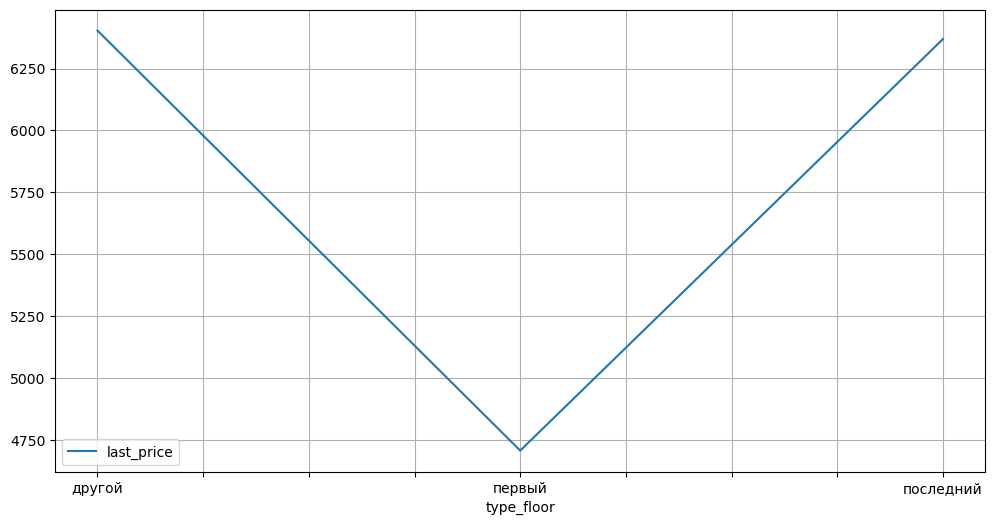

In [60]:
data.pivot_table(index = 'type_floor', values = 'last_price').plot(grid=True, figsize=(12, 6));
print(data['kitchen_area'].corr(data['last_price']))

Как и ожидалось, на первом этаже цены самые низкие. Кореляция 53%

-0.004811450534669042


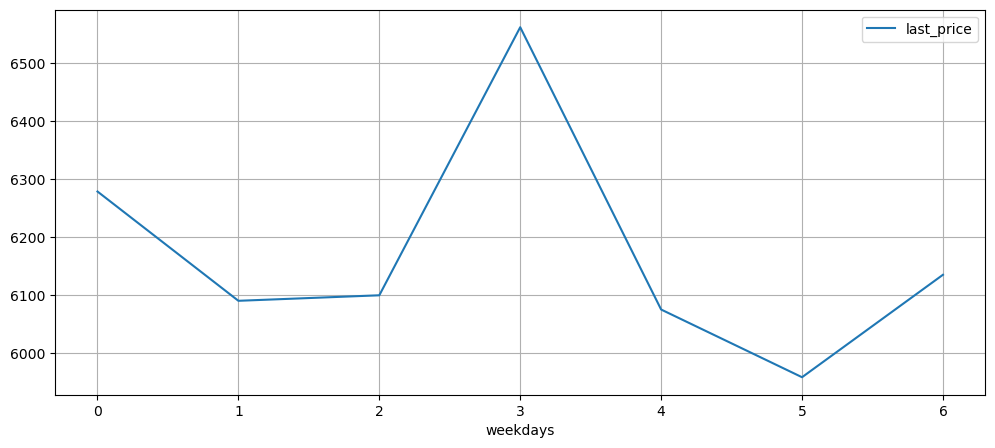

In [61]:
data.pivot_table(index = 'weekdays', values = 'last_price').plot(grid=True, figsize=(12, 5));
print(data['weekdays'].corr(data['last_price']))

In [62]:
display(data[data['weekdays'] == 3])

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_metr,weekdays,Month,Year,type_floor
0,20,13000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,...,1.0,482.0,2.0,755.0,NaN,120.37,3,3,2019,другой
2,10,5196.0,56.0,2015-08-20,2,2.55,5.0,34.3,4,False,...,1.0,90.0,2.0,574.0,558.0,92.79,3,8,2015,другой
6,6,3700.0,37.3,2017-11-02,1,2.66,26.0,10.6,6,False,...,0.0,NaN,0.0,NaN,155.0,99.20,3,11,2017,другой
10,5,5050.0,39.6,2017-11-16,1,2.67,12.0,20.3,3,False,...,1.0,310.0,2.0,553.0,137.0,127.53,3,11,2017,другой
12,10,3890.0,54.0,2016-06-30,2,2.55,5.0,30.0,5,False,...,0,NaN,0,NaN,90.0,72.04,3,6,2016,другой
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23544,10,3500.0,43.0,2016-05-19,2,2.50,3.0,26.1,2,False,...,0.0,NaN,1.0,1134.0,252.0,81.40,3,5,2016,другой
23548,11,2350.0,35.6,2016-06-23,1,2.50,5.0,17.0,4,False,...,0,NaN,0,NaN,40.0,66.01,3,6,2016,другой
23551,15,2490.0,31.0,2019-01-24,1,2.50,5.0,17.3,5,False,...,0.0,NaN,0.0,NaN,NaN,80.32,3,1,2019,другой
23556,3,5500.0,52.0,2018-07-19,2,2.55,5.0,31.0,2,False,...,1.0,300.0,0.0,NaN,15.0,105.77,3,7,2018,другой


Видно, что в четверг выставляли квартиры с большой ценой.

0.002693398166751331


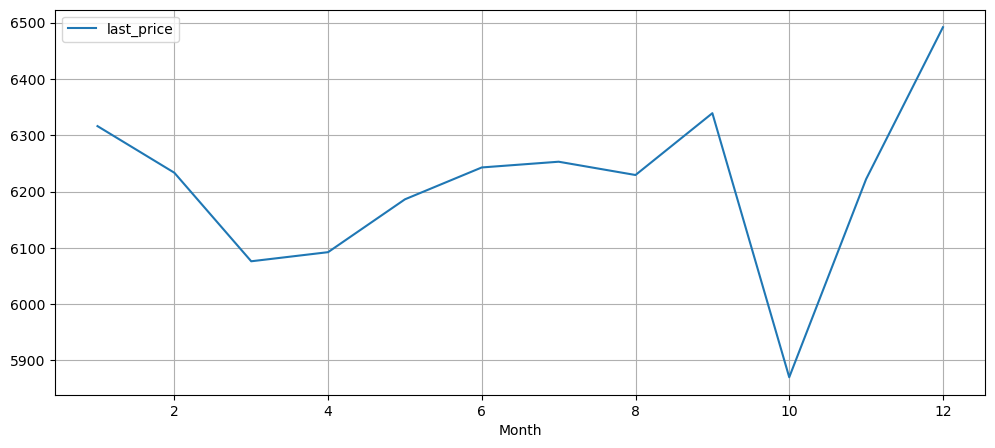

In [63]:
data.pivot_table(index = 'Month', values = 'last_price').plot(grid=True, figsize=(12, 5));
print(data['Month'].corr(data['last_price']))

Самые дешевые квартиры выставляются в Октябре, самые дорогие в декабре.

-0.051982679278835306


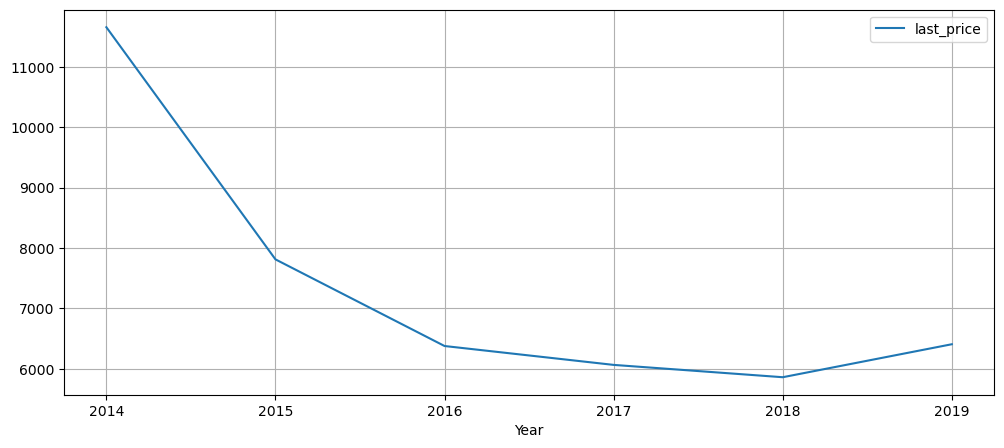

In [64]:
data.pivot_table(index = 'Year', values = 'last_price').plot(grid=True, figsize=(12, 5));
print(data['Year'].corr(data['last_price']))

Самые дорогие квартиры выставлялись в 2014 году.

По выведенным графикам видно, что зависимость цены присутствует везде, в основном зависимость положительная, кроме типа этажа. Действительно цена первых и последних намного занижена, чем у остальных. Зависимости цены от даты размещения не наблюдается.

#### Cредняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. 

                 count        mean
locality_name                     
Санкт-Петербург  13663  112.614749
Мурино             447   85.481074
Шушары             388   78.363041
Кудрово            371   95.071051
Всеволожск         345   68.795913
Пушкин             329  102.848480
Колпино            317   75.177098
Парголово          285   90.618912
Гатчина            283   68.577845
Петергоф           187   83.623743


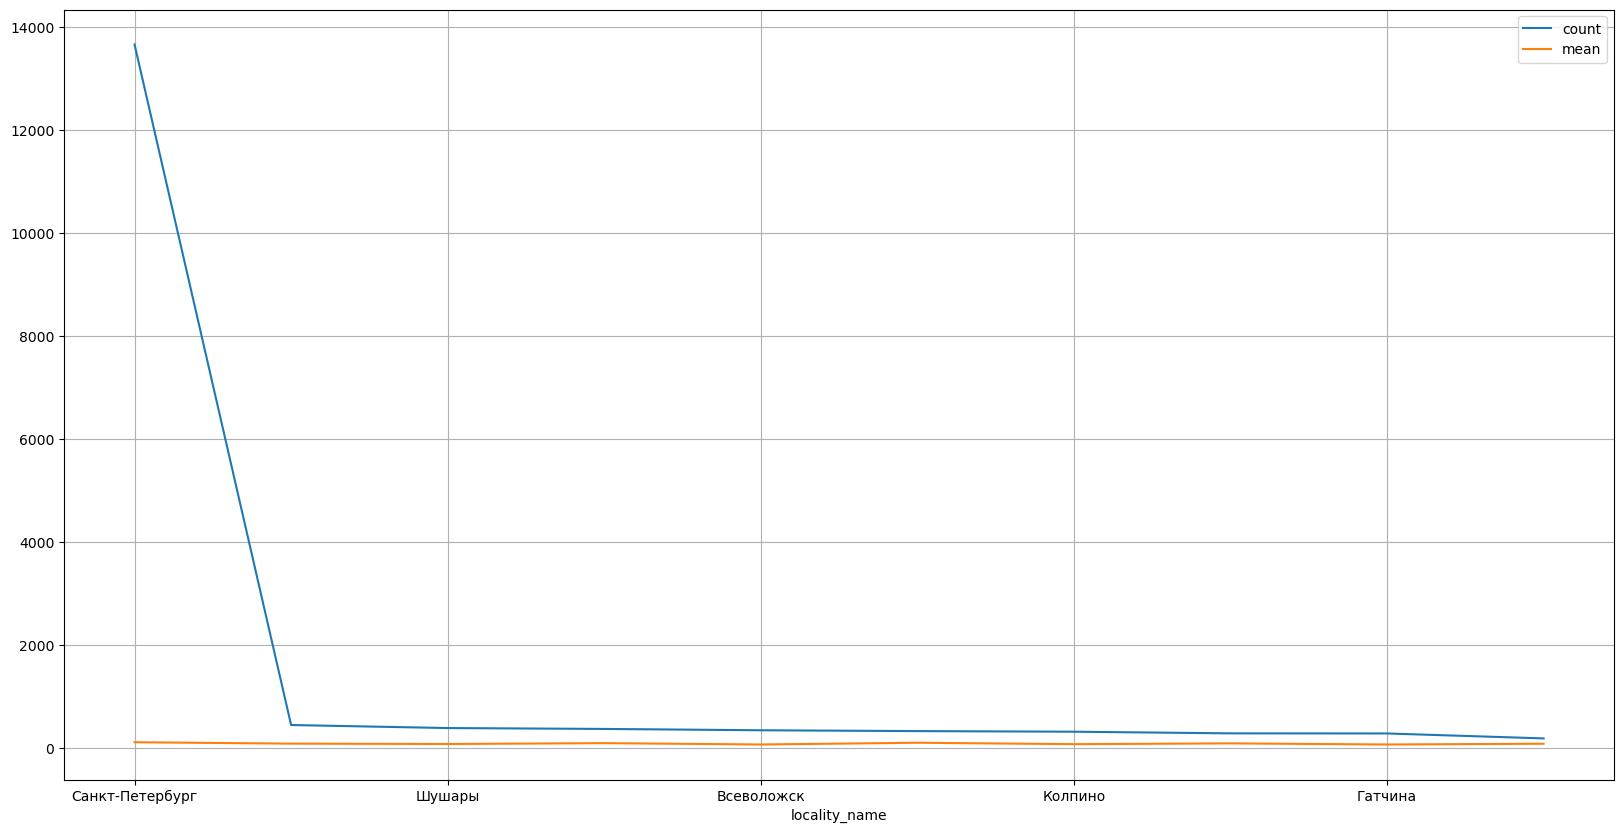

In [65]:
loc_data = data[['locality_name', 'price_one_metr']]
pivot_loc_data = (loc_data
                  .pivot_table(values = 'price_one_metr', index = 'locality_name', aggfunc = ('mean', 'count'))
                  .sort_values(by='count', ascending=False)
                  .head(10)
)

print(pivot_loc_data) # count - число обьявлений, mean - стоимость 1 кв.м.
pivot_loc_data.plot(grid=True, figsize=(20, 10));

В таблице и графике видно, что стоимость 1 кв.м. в Санкт-Петербурге выше, чем в остальных пригородных населенных пунктах.  
Выделить можно г. Пушкин, Ленинградской области. Цена за 1 кв.м. Выше, среди прочих. Возможно обусловленно это близостью к Царскому селу, что может влиять на спрос покупки вартир.  

Населённые пункты с самой высокой и низкой стоимостью квадратного метра.

In [66]:
print('высокая стоимость кв.метра:', pivot_loc_data[pivot_loc_data['mean'] == pivot_loc_data['mean'].max()])
print('низкая стоимость кв.метра:', pivot_loc_data[pivot_loc_data['mean'] == pivot_loc_data['mean'].min()])

высокая стоимость кв.метра:                  count        mean
locality_name                     
Санкт-Петербург  13663  112.614749
низкая стоимость кв.метра:                count       mean
locality_name                  
Гатчина          283  68.577845


#### Средняя цена за 1 км удаленности от цента. 

Средняя цена за 1 км удаленности от центра:  1494670.5  руб.


,locality_name,city_centers_nearest,price_one_metr,price_centr
63,Санкт-Петербург,5.0,169.49,3.389800e+06
15658,Санкт-Петербург,7.0,125.00,1.785714e+06
18282,Санкт-Петербург,12.0,113.67,9.472500e+05
9991,Санкт-Петербург,12.0,99.79,8.315833e+05
5388,Санкт-Петербург,12.0,88.79,7.399167e+05
12130,Санкт-Петербург,5.0,125.00,2.500000e+06
7952,Санкт-Петербург,15.0,67.65,4.510000e+05
17785,Санкт-Петербург,9.0,120.69,1.341000e+06
21707,Санкт-Петербург,12.0,99.55,8.295833e+05
14148,Санкт-Петербург,5.0,87.90,1.758000e+06


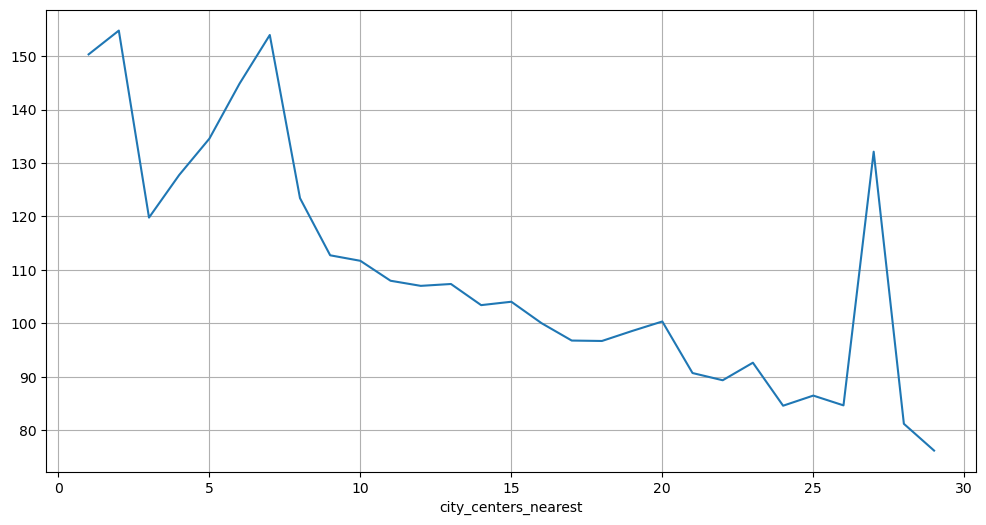

In [67]:
df = data[['locality_name', 'city_centers_nearest', 'price_one_metr']]
df = df[(df['locality_name'] == 'Санкт-Петербург') & (df['city_centers_nearest'] != 0)]
df['price_centr'] = df['price_one_metr'] / df['city_centers_nearest']
df.groupby('city_centers_nearest')['price_one_metr']\
  .mean()\
  .plot(x='cityCenters_nearest', y='price_centr', grid=True, figsize=(12, 6));
# возвращаем цену за рубли для корректного отображения стоимости.
df['price_centr'] = df['price_centr']*100000 
print('Средняя цена за 1 км удаленности от центра: ', round(df['price_centr'].mean(),2),' руб.')

df.sort_values(by='city_centers_nearest', ascending=True).sample(10)

Зависимость очевидна: чем дальше от центра, тем дешевле цена. Есть пики на 4 км и 27км.

### Общий вывод

Предобработка данных:  
На этапах предобработки были выявлены пропуски, дубликаты данных, а так же аномальные значения.  
Причиной появления пропусков может быть техническая ошибка, либо непредоставление данных клиентом.
Пропущенные значения были заменены. 
Явных дубликатов не выявлено. 
Неявные дубликаты выявлены в столбце `locality_name`. Устранили исключением типа населенного пункта.  
  
Аномальные значения были выявлены и устранены. Использовались различные методы и функции, а так же диаграмма размаха.  
Удалены строки всего на 6,37% из общего объёма таблицы, что является не критичным.

Были созданы дополнительные столбцы для построения графиков, гистограм для дальнейшего анализа особенностей и зависимостей.

Исследование данных и зависимостей:  
  
- обьекты  
Были построены гистограммы для понимания кучности распределения данных и выявления "выбросов", которые в дальнейшем могут испортить общую картину.
- Скорость продажи.
По средствам функций и гисторгаммы определена: средняя продолжительность продажи и минимальный срок.
- Факторы влияния на стоимость
Построив графики была выявлена прямая зависимость по всем параметрам, кроме даты размещения. Стоимость не зависит от даты и времени появления обьявления в Яндекс.Недвижимость.  
Посчитана средняя стоимость одного 1 кв.м. Самая высокая стоимость в Санкт-Петербурге, а самая низкая - в Выборге.
Посчитана цена за 1 км удаленности от центра. Так же определили, что стоимость в центре 109 090.91 руб/кв.м., на окраине 56 526.81 руб/кв.м. 

Резюмируя можно сказать:  
Цели выполнены, рыночную стоимость определили, выявили зависимости и особенности.

Рекомендации:
Добавить информацию об адресах обьектов для полноты картины и проверки некоторых полей исходной таблицы. В исходной таблице нехватало данных для более точного анализа. Рекомендуется дополнительно сделать обязательными поля ввода для пользователей, которые идут на обработку картографических данных, тем самым можно исключить такое массовое появление пустых значений.